In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

from skimage.io import imread
from skimage.transform import resize
from skimage.morphology import label

from keras.models import load_model

IMG_WIDTH = IMG_HEIGHT = 256
IMG_CHANNELS = 3

Using TensorFlow backend.
/home/appsyoon/miniconda3/envs/retinanet/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def plot_loss_history(history_path):
    with (open(history_path, 'rb')) as file:
        history = pickle.load(file)
    
    # validation losses
    val_loss = history['val_loss']
    loss = history['loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.show()

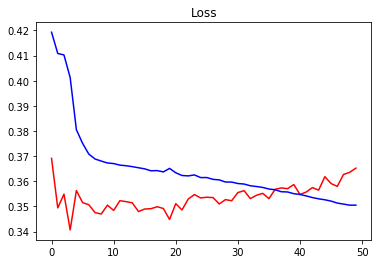

In [3]:
plot_loss_history('./history.pkl')

In [4]:
model = load_model('./snapshots/keras_unet_50.h5')

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [6]:
def preprocess_test(path, input_size):
    test_ids = next(os.walk(path))[1]

    test_X = np.zeros((len(test_ids), input_size[0], input_size[1], input_size[2]), dtype=np.uint8)
    # we are going to resize the predicted test images back to original size
    test_image_sizes = []

    for index_, test_id in tqdm(enumerate(test_ids), total=len(test_ids)):
        image_path = path + test_id + '/images/' + test_id + '.png'
        image = imread(image_path)
        dims = len(image.shape)
        if dims > 2:
            image = image[:,:,:input_size[2]]
        elif dims == 2:
            image = np.expand_dims(image, axis=-1)        
        test_image_sizes.append((image.shape[0], image.shape[1]))
        resized = resize(image, (input_size[0], input_size[1]), mode='constant', preserve_range=True)
        test_X[index_] = resized

    return (test_X, test_ids, test_image_sizes)

In [7]:
test_X, test_ids, test_image_sizes = preprocess_test(path='./data/stage2_test/', input_size=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

100%|██████████| 3019/3019 [00:50<00:00, 59.60it/s]


In [8]:
predictions = model.predict(test_X, verbose=1)

3019/3019 [==============================] - 472s 156ms/step


In [9]:
predictions = np.squeeze(predictions)

In [10]:
np.amax(predictions)

0.97905618

In [ ]:
index_ = random.randint(0, len(test_X))

plt.imshow(test_X[index_])
plt.show()

plt.imshow(predictions[index_] > 0.2)
plt.show()

In [ ]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[
        0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b

    return run_lengths


def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)


In [ ]:
all_preds = []

for i in range(1, 51):
    filename = 'keras_unet_{0:0>2}.h5'.format(i)
    print(filename)
    model = load_model('./snapshots/' + filename)
    preds = model.predict(test_X)
    preds = np.squeeze(preds)

    # resizing the predictions to original size
    preds_resized = []
    for index, pred in enumerate(preds):
        image = resize(pred, test_image_sizes[index], mode='constant', preserve_range=True)
        preds_resized.append(image)

    all_preds.append(preds_resized)

keras_unet_01.h5
keras_unet_02.h5
keras_unet_03.h5
keras_unet_04.h5


In [ ]:
for i, preds in enumerate(all_preds):
    pred_ids = []
    rles = []
    for index, id_ in enumerate(test_ids):
        rle = list(prob_to_rles(preds[index], cutoff=0.3))
        rles.extend(rle)
        pred_ids.extend([id_] * len(rle))
    
    unique_test = set(pred_ids)
    if len(unique_test) == len(test_ids):
        print('Found a result for epoch {}'.format(i + 1))
        submission = pd.DataFrame()
        submission['ImageId'] = pred_ids
        submission['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
        submission.to_csv('submission_{}.csv'.format(i + 1), index=False)